In [2]:
!python --version


Python 3.10.12


In [3]:
!pip install tensorflow==2.11.0
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 883.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 45.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: keras
    Found existing installation: ke

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-yq1winva
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-yq1winva
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431845 sha256=90c3e2ba02fe4c639f4e9e91221b1188391d0890453ffe7c4136ccb29637369d
  Stored in directory: /tmp/pip-ephem-wheel-cache-bn9po0qn/wheels/f3/06/0f/089f69af27d308a1830638f855b6c5755311d8ffc451de9980
Successfully built stellargraph


In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)


In [3]:
  print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [5]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


In [6]:
epochs = 50


In [7]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)


Using GCN (local pooling) filters...


In [8]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [9]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [10]:
x_inp, x_out = gcn.in_out_tensors()

In [11]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [12]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [13]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [14]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 65ms/step - loss: 1.8395 - acc: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 1.8353
	acc: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 1.8395
	acc: 0.0000


In [15]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 1.7565 - acc: 0.0000e+00 - val_loss: 1.5645 - val_acc: 0.0000e+00 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 1.4884 - acc: 0.0000e+00 - val_loss: 1.3314 - val_acc: 0.0000e+00 - 141ms/epoch - 141ms/step
Epoch 3/50
1/1 - 0s - loss: 1.2868 - acc: 0.0000e+00 - val_loss: 1.1333 - val_acc: 0.0000e+00 - 131ms/epoch - 131ms/step
Epoch 4/50
1/1 - 0s - loss: 1.1080 - acc: 0.0000e+00 - val_loss: 0.9692 - val_acc: 0.0000e+00 - 156ms/epoch - 156ms/step
Epoch 5/50
1/1 - 0s - loss: 0.9343 - acc: 0.0000e+00 - val_loss: 0.8370 - val_acc: 0.0000e+00 - 210ms/epoch - 210ms/step
Epoch 6/50
1/1 - 0s - loss: 0.8330 - acc: 0.0000e+00 - val_loss: 0.7374 - val_acc: 0.0000e+00 - 205ms/epoch - 205ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7519 - acc: 0.0000e+00 - val_loss: 0.6853 - val_acc: 0.0000e+00 - 164ms/epoch - 164ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7418 - acc: 0.0000e+00 - val_loss: 0.7022 - val_acc: 0.0000e+00 - 165ms/epoch - 165ms/step
Epoch 9/50
1/1 - 0s - loss: 0.8529 - a

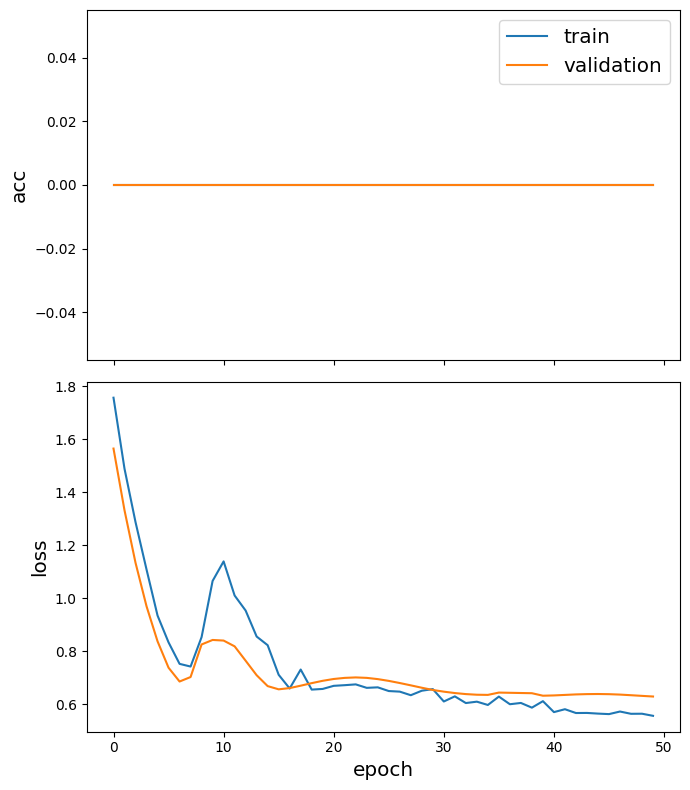

In [16]:
sg.utils.plot_history(history)


In [17]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 56ms/step - loss: 0.6287 - acc: 0.0000e+00

Train Set Metrics of the trained model:
	loss: 0.5299
	acc: 0.0000

Test Set Metrics of the trained model:
	loss: 0.6287
	acc: 0.0000
